In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

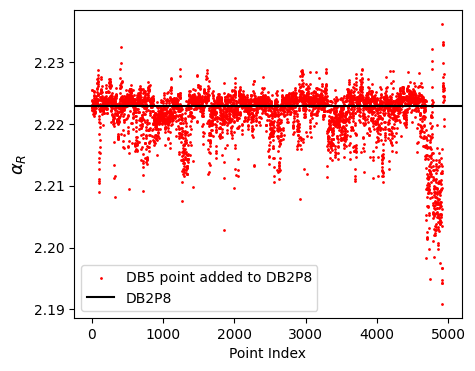

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(reg_data.index, reg_data.αR, s=1, c="r", label="DB5 point added to DB2P8")
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.xlabel("Point Index")
plt.ylabel("$\\alpha_R$", fontsize=13)
plt.legend();

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)


# Ordering dataset ids from smallest to greatest alpha-R 

dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

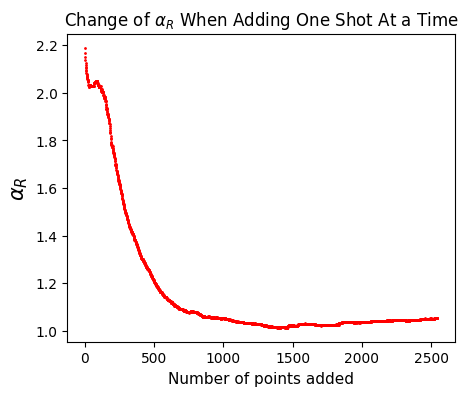

In [8]:
#%matplotlib notebook

plt.figure(figsize=(5,4))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=1, c = "r")
plt.xlabel("Number of points added", fontsize=11)
plt.ylabel("$\\alpha_R$", fontsize=15)
plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time");

In [9]:
# Labeling shots that decreased or increased the overall regression when added
df = DB5_decreas_pts[["αR_per_pts_in_DB2"]]
df.insert(0, "prev_val", [regression_DB2.params[5]] + list(df["αR_per_pts_in_DB2"].iloc[:-1].values))
df.insert(0, "difference", df["αR_per_pts_in_DB2"] - df["prev_val"])
DB5_decreas_pts.insert(0, "decreased", df.difference.apply(lambda x: 1 if x<=0 else 0))
DB5_decreas_pts.insert(0, "weights", DB5_decreas_pts.decreased.values/len(DB5_decreas_pts) + 1 )

In [10]:
num_samples = 5


max_amount = len( DB5_decreas_pts ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='weights', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]

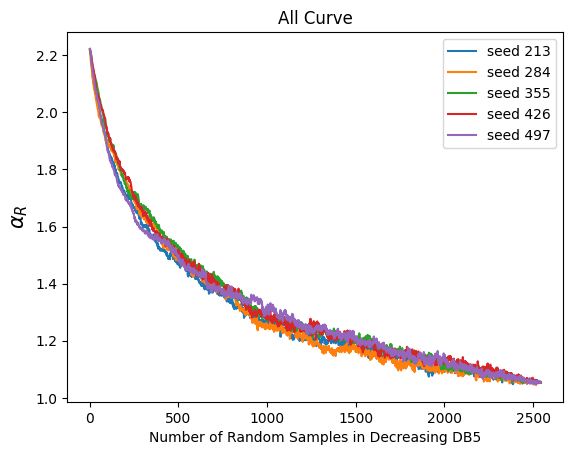

In [11]:
for s in range(num_samples):
    plt.plot(range(1, max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.legend()
plt.title("All Curve")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15);

In [12]:
for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))

1.047692850846871 2385
1.0469016563959335 2507
1.0504337866203382 2441
1.0521250138652025 2535
1.0452796614160078 2516


In [13]:
max_amount = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='decreased', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]

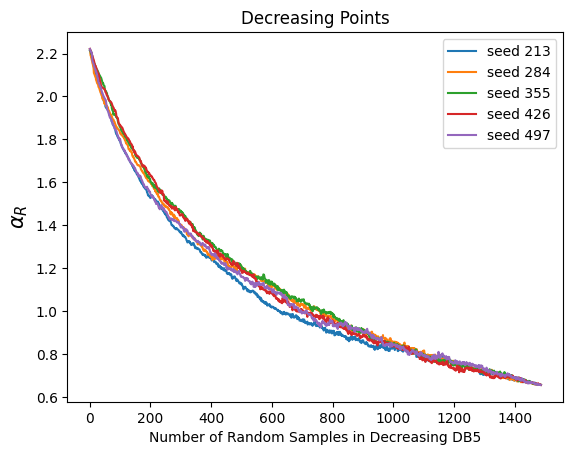

In [14]:
for s in range(num_samples):
    plt.plot(range(1,max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.legend()
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15);

In [15]:
for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))

0.6558006008429031 1485
0.6558006008429019 1485
0.6558006008429 1485
0.6558006008429005 1485
0.6555141955179472 1479


## Close-Up Analyses

In [16]:
max_amount  = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
num_samples = 500
min_subset  = 600

max_amount = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
SAMPLES_cl = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(min_subset, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='decreased', random_state=71*(i + 3))
        SAMPLES_cl[i,j-1] = get_regression_np(R_sampled)[1].params[5]

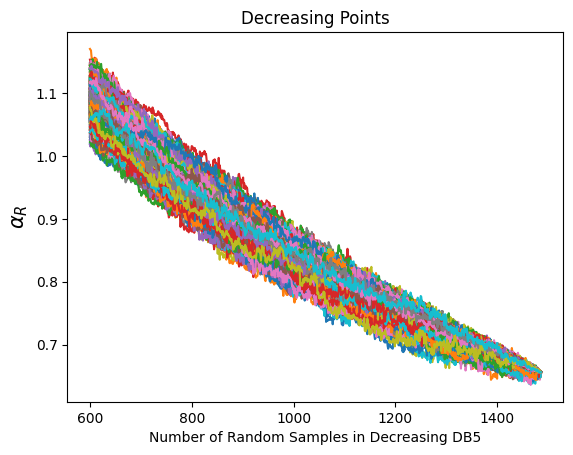

In [17]:
for s in range(num_samples):
    plt.plot(range(min_subset, max_amount), SAMPLES_cl[s,min_subset-1:])
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15);

In [31]:
random_sampling = pd.DataFrame(
    SAMPLES_cl[:,min_subset-1:], 
    columns = [f"subset_{i}"for i in range(min_subset, max_amount)]
)
random_sampling["seed"] = [71*(i + 3) for i in range(num_samples)]
random_sampling.set_index("seed", inplace=True)

In [38]:
random_sampling.describe()

,subset_600,subset_601,subset_602,subset_603,subset_604,subset_605,subset_606,subset_607,subset_608,subset_609,subset_610,subset_611,subset_612,subset_613,subset_614,subset_615,subset_616,subset_617,subset_618,subset_619,subset_620,subset_621,subset_622,subset_623,subset_624,subset_625,subset_626,subset_627,subset_628,subset_629,subset_630,subset_631,subset_632,subset_633,subset_634,subset_635,subset_636,subset_637,subset_638,subset_639,subset_640,subset_641,subset_642,subset_643,subset_644,subset_645,subset_646,subset_647,subset_648,subset_649,subset_650,subset_651,subset_652,subset_653,subset_654,subset_655,subset_656,subset_657,subset_658,subset_659,subset_660,subset_661,subset_662,subset_663,subset_664,subset_665,subset_666,subset_667,subset_668,subset_669,subset_670,subset_671,subset_672,subset_673,subset_674,subset_675,subset_676,subset_677,subset_678,subset_679,subset_680,subset_681,subset_682,subset_683,subset_684,subset_685,subset_686,subset_687,subset_688,subset_689,subset_690,subset_691,subset_692,subset_693,subset_694,subset_695,subset_696,subset_697,subset_698,subset_699,subset_700,subset_701,subset_702,subset_703,subset_704,subset_705,subset_706,subset_707,subset_708,subset_709,subset_710,subset_711,subset_712,subset_713,subset_714,subset_715,subset_716,subset_717,subset_718,subset_719,subset_720,subset_721,subset_722,subset_723,subset_724,subset_725,subset_726,subset_727,subset_728,subset_729,subset_730,subset_731,subset_732,subset_733,subset_734,subset_735,subset_736,subset_737,subset_738,subset_739,subset_740,subset_741,subset_742,subset_743,subset_744,subset_745,subset_746,subset_747,subset_748,subset_749,subset_750,subset_751,subset_752,subset_753,subset_754,subset_755,subset_756,subset_757,subset_758,subset_759,subset_760,subset_761,subset_762,subset_763,subset_764,subset_765,subset_766,subset_767,subset_768,subset_769,subset_770,subset_771,subset_772,subset_773,subset_774,subset_775,subset_776,subset_777,subset_778,subset_779,subset_780,subset_781,subset_782,subset_783,subset_784,subset_785,subset_786,subset_787,subset_788,subset_789,subset_790,subset_791,subset_792,subset_793,subset_794,subset_795,subset_796,subset_797,subset_798,subset_799,subset_800,subset_801,subset_802,subset_803,subset_804,subset_805,subset_806,subset_807,subset_808,subset_809,subset_810,subset_811,subset_812,subset_813,subset_814,subset_815,subset_816,subset_817,subset_818,subset_819,subset_820,subset_821,subset_822,subset_823,subset_824,subset_825,subset_826,subset_827,subset_828,subset_829,subset_830,subset_831,subset_832,subset_833,subset_834,subset_835,subset_836,subset_837,subset_838,subset_839,subset_840,subset_841,subset_842,subset_843,subset_844,subset_845,subset_846,subset_847,subset_848,subset_849,subset_850,subset_851,subset_852,subset_853,subset_854,subset_855,subset_856,subset_857,subset_858,subset_859,subset_860,subset_861,subset_862,subset_863,subset_864,subset_865,subset_866,subset_867,subset_868,subset_869,subset_870,subset_871,subset_872,subset_873,subset_874,subset_875,subset_876,subset_877,subset_878,subset_879,subset_880,subset_881,subset_882,subset_883,subset_884,subset_885,subset_886,subset_887,subset_888,subset_889,subset_890,subset_891,subset_892,subset_893,subset_894,subset_895,subset_896,subset_897,subset_898,subset_899,subset_900,subset_901,subset_902,subset_903,subset_904,subset_905,subset_906,subset_907,subset_908,subset_909,subset_910,subset_911,subset_912,subset_913,subset_914,subset_915,subset_916,subset_917,subset_918,subset_919,subset_920,subset_921,subset_922,subset_923,subset_924,subset_925,subset_926,subset_927,subset_928,subset_929,subset_930,subset_931,subset_932,subset_933,subset_934,subset_935,subset_936,subset_937,subset_938,subset_939,subset_940,subset_941,subset_942,subset_943,subset_944,subset_945,subset_946,subset_947,subset_948,subset_949,subset_950,subset_951,subset_952,subset_953,subset_954,subset_955,subset_956,subset_957,subset_958,subset_959,subset_960,subset_961,subset_962,subset

In [46]:
# Found Subset with Minimum alpha_R
random_sampling.describe().loc["min"].keys()[np.argmin(random_sampling.describe().loc["min"])]

'subset_1466'

In [47]:
# Minimum alpha_R generated by random sampling
min(random_sampling.describe().loc["min"]) 

0.6357571952782819

In [52]:
# Seed that generated the minimum alpha_R with 1466 sampling
random_sampling[random_sampling["subset_1466"].isin([ min(random_sampling.describe().loc["min"])  ])].index

Int64Index([25489], dtype='int64', name='seed')

In [54]:
#random_sampling.to_csv(path+"random_sampling_min_subset.csv")

In [55]:
R_ = DB5_decreas_pts.sample(n=1466, weights='decreased', random_state=25489)
R_

,weights,decreased,ind,id,PHASE,TOK,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,TAUTH,DATE,SHOT,TIME,Q95,ZEFF,AMIN,VOL,POHM,PNBI,DWDIA,DWMHD,PICRH,PECRH,PL,PFLOSS,TAV,LCOULOMB,QCYL5,TAUBOHM,RHOSTAR,BETASTAR,NUSTAR,OMEGACYCL,αR_per_pts_in_DB2
ordered,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1695,1.000393,1,15741,NZONFW,HGELM,AUGW,-0.003305,0.898534,2.138418,1.629241,0.481191,0.463734,-1.123645,0.693147,-2.354510,20120316,27562,3.25,1.559827,NaN,0.526000,14.050000,663800.000000,4.987000e+06,NaN,6896.0,0.000000e+00,0.0,5.640000e+06,324300.000000,962.431344,14.881857,1.225132,0.116586,-5.320472,-0.039952,-1.031238,1.228000,1.023012
421,1.000393,1,22633,1O4PQQ,HGELMH,JETILW,0.903691,0.981271,2.116035,2.940501,1.068311,0.438789,-1.160782,0.682232,-1.621661,20160122,89702,52.30,1.203099,1.540350,0.911675,74.051597,865513.636364,1.491320e+07,-21922.9,28231.1,3.280494e+06,0.0,1.908113e+07,155800.443381,1440.536379,15.296356,0.895160,0.266436,-5.756996,0.175500,-1.519912,1.348562,1.294118
1775,1.000393,1,15657,ONMHZ9,HGELM,AUGW,-0.003105,0.867521,2.077565,1.574846,0.481809,0.461845,-1.128072,0.693147,-2.388034,20110324,26627,3.25,1.522572,NaN,0.524000,13.930000,395800.000000,4.803000e+06,NaN,-105200.0,0.000000e+00,0.0,5.350000e+06,519900.000000,943.512775,14.892431,1.184443,0.109300,-5.295576,-0.058630,-1.085105,1.190500,1.025262
935,1.000393,1,22914,NQGQCG,HGELMH,JETILW,0.604648,1.018583,1.423139,2.635243,1.067260,0.409142,-1.140909,0.655946,-1.834922,20161005,91902,51.45,1.464903,1.456052,0.928997,74.567758,359568.869565,9.550819e+06,10074.0,-13640.5,4.396471e+06,0.0,1.429678e+07,350083.463434,1703.093291,15.810235,1.233260,0.229401,-5.742557,-0.424589,-2.207385,1.437114,1.053879
938,1.000393,1,15146,52CYZO,HGELM,AUG,0.001000,0.911479,1.548626,1.947338,0.506215,0.494696,-1.253396,0.693147,-2.378171,20030314,17220,6.05,1.354288,1.672000,0.473700,12.040000,153500.000000,4.932000e+06,NaN,-53530.0,2.314000e+06,0.0,7.450000e+06,368700.000000,2716.878030,16.214529,1.025555,0.115344,-4.709802,0.382142,-3.590743,1.244000,1.054648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1.000393,1,14680,9RZQQA,HGELM,AUG,0.001000,0.741461,1.712536,1.913977,0.508623,0.494086,-1.257706,0.693147,-2.256656,20020110,15025,2.60,1.184484,2.502000,0.472800,12.020000,148800.000000,7.263000e+06,NaN,-101700.0,0.000000e+00,0.0,7.510000e+06,531200.000000,2522.813190,16.058465,0.849928,0.109883,-4.574937,0.811980,-3.455041,1.049500,1.076872
816,1.000393,1,20785,9ZUHRI,HGELM,JET,0.941958,1.014143,1.759753,2.421257,1.064366,0.468104,-1.121360,0.691646,-1.145075,19980116,44030,61.63,1.264692,2.108000,0.944600,81.540000,718600.000000,1.073000e+07,4436.0,NaN,0.000000e+00,0.0,1.144000e+07,176200.000000,1790.698661,15.692088,0.986112,0.439298,-5.711843,-0.028936,-2.257959,1.380571,1.074750
1188,1.000393,1,16276,3VR4J8,HGELM,AUGW,-0.515671,0.611395,1.959108,1.976855,0.484892,0.366724,-1.147316,0.693147,-3.395613,20171026,34946,3.45,1.624917,NaN,0.515600,12.290000,190000.000000,7.264000e+06,NaN,9360.0,0.000000e+00,0.0,7.440000e+06,195500.000000,605.618469,14.508299,1.312025,0.030889,-5.244969,-0.108195,-0.183442,0.921500,1.033112


In [56]:
get_regression_np(R_)[1].params[5]

0.6357571952782819

In [62]:
#R_[["id"]].to_csv(path+"R_ids_alpha_0.6357.csv", index=False)